In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt


In [3]:
#load data from parquet file
raw_data = pd.read_parquet('mag7_ticker_first.parquet')

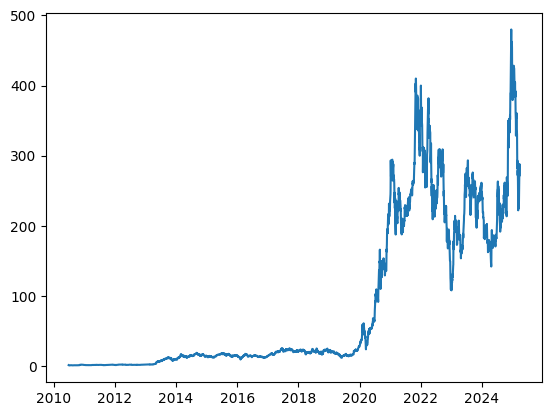

In [4]:
plt.plot(raw_data.index, raw_data['TSLA', 'Close'])

In [5]:
index = pd.date_range(
    start=raw_data.index[0], end=raw_data.index[-1], freq='B'
)
#new = pd.DataFrame(raw_data, index=index).ffill().bfill()
new = pd.DataFrame(raw_data, index=index)

In [6]:
raw_data.index[0]

Timestamp('2006-03-27 00:00:00')

In [7]:
#print NaN values of new['AAPL', 'Close']
print(new['AAPL', 'Close'][new['AAPL', 'Close'].isnull()])



2006-04-14   NaN
2006-05-29   NaN
2006-07-04   NaN
2006-09-04   NaN
2006-11-23   NaN
              ..
2024-12-25   NaN
2025-01-01   NaN
2025-01-09   NaN
2025-01-20   NaN
2025-02-17   NaN
Name: (AAPL, Close), Length: 177, dtype: float64


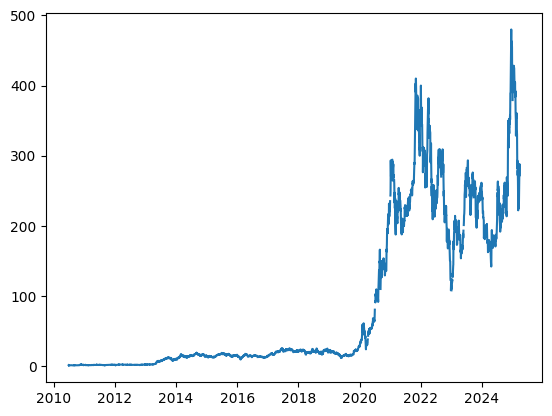

In [8]:
plt.plot(new.index, new['TSLA', 'Close'])

In [9]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "META", "TSLA"]  # Mag7
lookback = 20
n_assets = len(tickers)
n_channels = 1
batch_size = 16
horizon = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
from matplotlib import axis
from pandas import DataFrame

new = new[tickers]
def get_stock_data(df , start="2017-01-01", end="2025-05-18"):

    # copy df data to a new DataFrame
    df = df.copy()
    df.columns = df.columns.swaplevel(0, 1)
    returns = df["Close"].pct_change(fill_method=None) #.dropna()
    df.columns = df.columns.swaplevel(0, 1)
    # drop first row of dataframe
    # df = df.iloc[1:-1]
    # returns = returns.iloc[1:-1]
    return df, returns

def format_to_text(data, ticker):
    texts = []
    for date, row in data.iterrows():
        text = f"经过前复权之后，{date.strftime('%Y-%m-%d')} {ticker} 开盘价是 {row['Open']:.2f}，收盘价是 {row['Close']:.2f}，成交额是 {row['Volume']:.0f}"
        texts.append(text)
    return texts

data, returns = get_stock_data(new)
text_data = {ticker: format_to_text(data[ticker], ticker) for ticker in tickers}
timestamps = data.index.tolist()

In [11]:
text_data['TSLA'][1000], text_data['TSLA'][3000]

('经过前复权之后，2010-01-25 TSLA 开盘价是 nan，收盘价是 nan，成交额是 nan',
 '经过前复权之后，2017-09-25 TSLA 开盘价是 23.54，收盘价是 23.00，成交额是 114088500')

In [12]:
# transform text_data to a DataFrame
text_df = pd.DataFrame(text_data, index=timestamps)

In [13]:
text_df.to_parquet('mag7_text.parquet')

In [14]:
for key, texts in text_df.items():
    print(f"Ticker: {key}")
    for text in texts:
        print(text)
    print("\n")
    break

Ticker: AAPL
经过前复权之后，2006-03-27 AAPL 开盘价是 1.81，收盘价是 1.79，成交额是 1108072000
经过前复权之后，2006-03-28 AAPL 开盘价是 1.79，收盘价是 1.76，成交额是 1370322800
经过前复权之后，2006-03-29 AAPL 开盘价是 1.78，收盘价是 1.87，成交额是 2346834000
经过前复权之后，2006-03-30 AAPL 开盘价是 1.89，收盘价是 1.89，成交额是 1390650800
经过前复权之后，2006-03-31 AAPL 开盘价是 1.90，收盘价是 1.88，成交额是 815357200
经过前复权之后，2006-04-03 AAPL 开盘价是 1.91，收盘价是 1.88，成交额是 815791200
经过前复权之后，2006-04-04 AAPL 开盘价是 1.87，收盘价是 1.84，成交额是 931924000
经过前复权之后，2006-04-05 AAPL 开盘价是 1.94，收盘价是 2.02，成交额是 2233408800
经过前复权之后，2006-04-06 AAPL 开盘价是 2.05，收盘价是 2.14，成交额是 2663768800
经过前复权之后，2006-04-07 AAPL 开盘价是 2.13，收盘价是 2.10，成交额是 1545238800
经过前复权之后，2006-04-10 AAPL 开盘价是 2.11，收盘价是 2.06，成交额是 903515200
经过前复权之后，2006-04-11 AAPL 开盘价是 2.07，收盘价是 2.04，成交额是 939316000
经过前复权之后，2006-04-12 AAPL 开盘价是 2.04，收盘价是 2.00，成交额是 739894400
经过前复权之后，2006-04-13 AAPL 开盘价是 1.99，收盘价是 2.00，成交额是 734678000
经过前复权之后，2006-04-14 AAPL 开盘价是 nan，收盘价是 nan，成交额是 nan
经过前复权之后，2006-04-17 AAPL 开盘价是 2.00，收盘价是 1.95，成交额是 721938000
经过前复权之后，2006-04-18 AAPL 开盘价是 1.95，收盘价是 1.99，

In [ ]:
from ollama import Client

ollama_client = Client()
system_prompt = """
你是顶级股票操盘手，注意你需要全程使用中文。请回忆该特定时间点之前一年以内：对该股票影响最大的财经信息和宏观数据，以及对该公司的深度洞察。输出格式是python dict。
"""
def generate_texts_with_ollama(texts, model="gemma3:27b", max_retries=3, batch_size=10):
    """
    Use Ollama to generate texts in batches
    Args:
        texts: List of input texts
        model: Model name, default is gemma3-12b
        max_retries: Maximum number of retries per text
        batch_size: Number of texts to process in one batch
    Returns:
        List of generated texts
    """
    generated_texts = []
    
    # Process texts in batches
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        print(f"Processing batch {i//batch_size + 1} of {len(texts)//batch_size + 1}...")
        
        for text in batch:
            for attempt in range(max_retries):
                try:
                    response = ollama_client.chat(
                        model=model,
                        messages=[{"role": "system", "content": system_prompt},
                                  {"role": "user", "content": text}],
                        options={
                            "num_ctx": 1000,
                            "temperature": 0.01
                        }
                    )
                    print(f"Generated text for: {response['message']['content']}")
                    generated_texts.append(response['message']['content'])
                    break
                except Exception as e:
                    print(f"Error processing text: {e}. Attempt {attempt + 1}/{max_retries}")
                    if attempt == max_retries - 1:
                        generated_texts.append(f"Failed to generate: {text}")
    
    return generated_texts

def process_text_data(text_data, batch_size=10):
    """
    Process text_data dictionary and generate texts in batches
    Args:
        text_data: Dictionary with ticker and list of texts
        batch_size: Number of texts to process in one batch
    Returns:
        Dictionary with generated texts
    """
    generated_texts = {}
    
    for ticker, texts in text_data.items():
        print(f"Generating texts for {ticker}...")
        generated_texts[ticker] = generate_texts_with_ollama(texts, batch_size=batch_size)
    
    return generated_texts

llm_output_texts = process_text_data(text_df.head(), batch_size=1)

Generating texts for AAPL...
Processing batch 1 of 6...


Generated text for: 好的，没问题。作为顶级股票操盘手，我将深入分析2006年3月27日AAPL（苹果公司）股票价格波动，并提供影响因素分析。以下是基于过去一年（2005年3月27日至2006年3月27日）的分析结果，以Python字典形式呈现。

```python
{
    "股票代码": "AAPL",
    "日期": "2006-03-27",
    "开盘价（前复权）": 1.81,
    "收盘价（前复权）": 1.79,
    "成交额": 1108072000,
    "核心观点": "2006年初，苹果公司正处于从音乐播放器市场向智能手机市场转型的关键时期。虽然iPod的销量依然强劲，但市场对iPhone的期待和担忧并存。宏观经济环境相对稳定，但能源价格上涨对供应链和消费者支出构成潜在风险。当日股价下跌可能受到获利回吐和对iPhone发布前的谨慎情绪影响。",
    "影响因素分析": {
        "宏观经济数据": {
            "GDP增长": "2005年美国GDP增长率为3.5%，2006年一季度初步估计为2.5%。经济增长放缓可能对消费电子产品的需求产生一定影响。",
            "利率": "美联储在2005年持续加息，联邦基金利率从2%上升至4.25%。加息增加了企业的融资成本，可能抑制投资和消费。",
            "通货膨胀": "2005年通货膨胀率约为3.4%，主要受能源价格上涨驱动。通胀压力可能降低消费者的可支配收入。",
            "失业率": "2005年失业率维持在5%左右，表明劳动力市场相对稳定。",
            "油价": "2005年油价大幅上涨，布伦特原油价格从50美元/桶上涨至70美元/桶。油价上涨增加了苹果公司的生产成本和运输成本，也可能抑制消费者的购买力。"
        },
        "行业信息": {
            "移动电话市场": "2005年移动电话市场竞争激烈，诺基亚、摩托罗拉等传统厂商占据主导地位。智能手机市场开始兴起，但市场份额相对较小。",
            "MP3播放器市场": "iPod在MP3播放器市场占据绝对优势，但竞争对手如Creative也在不断

In [20]:
# 步骤 2：使用 Qwen2 0.5B 提取隐藏层特征
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-0.6B")
llm_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen3-0.6B").to(device)
llm_model.eval()

def extract_hidden_features(texts, max_length=128):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)
    with torch.no_grad():
        outputs = llm_model(**inputs, output_hidden_states=True)
    last_hidden_state = outputs.hidden_states[-1] #len(hidden_states))          # 层数 + 1（包含 embedding 层）
    return last_hidden_state #outputs.last_hidden_state[:, 0, :]

features = []
for ticker in tickers:
    ticker_texts = text_data[ticker]
    batch_texts = [ticker_texts[i:i+batch_size] for i in range(0, len(ticker_texts), batch_size)]
    ticker_features = []
    for batch in batch_texts:
        batch_features = extract_hidden_features(batch)
        #add meanpool
        batch_features = torch.mean(batch_features, dim=1)
        ticker_features.append(batch_features)
    ticker_features = torch.cat(ticker_features, dim=0)
    features.append(ticker_features)

features = torch.stack(features, dim=-1)  # (n_timesteps, hidden_size, n_assets)

In [27]:
from transformers import AutoModelForCausalLM, AutoTokenizer


system_prompt = """输入中包含在特定时间点的股票开盘价、收盘价和成交量。请根据这些信息回忆该特定时间点之前，对该股票价格影响最大的全球财经事件"""
# prepare the model input
prompt = "2006-03-27 AAPL 开盘价是 1.81，收盘价是 1.79，成交量是 1108072000。\n请回忆该特定时间点之前，对该股票价格影响最大的全球财经事件。"
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=True # Switches between thinking and non-thinking modes. Default is True.
)
model_inputs = tokenizer([text], return_tensors="pt").to(llm_model.device)

# conduct text completion
generated_ids = llm_model.generate(
    **model_inputs,
    max_new_tokens=32768
)
output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist() 

# parsing thinking content
try:
    # rindex finding 151668 (</think>)
    index = len(output_ids) - output_ids[::-1].index(151668)
except ValueError:
    index = 0

thinking_content = tokenizer.decode(output_ids[:index], skip_special_tokens=True).strip("\n")
content = tokenizer.decode(output_ids[index:], skip_special_tokens=True).strip("\n")

print("thinking content:", thinking_content)
print("content:", content)


thinking content: <think>
好的，用户问的是2006年3月27日苹果公司（AAPL）的开盘价、收盘价和成交量，然后要回忆该时间点之前影响最大的全球财经事件。首先，我需要确定用户的需求是什么。他们可能是在学习财经分析，或者需要历史数据来模拟某个事件的影响，或者只是想了解过去某个时间点的事件如何影响股票价格。

接下来，我需要回忆2006年3月27日之前的相关事件。苹果公司作为一个科技巨头，2005年之前可能经历了几次重要的经济事件。比如，2001年经济衰退，或者2003年全球金融危机。不过，2006年3月27日是苹果公司成立后的第12年，可能更接近某个事件。

另外，苹果公司在2005年推出了iPhone，这可能是一个关键事件。iPhone的发布可能对苹果的股价有直接影响。但需要确认苹果在2005年之前是否有其他重大事件。比如，2003年全球金融危机，虽然发生在更早，但可能影响了市场情绪，但具体到苹果公司，可能更直接的是iPhone的发布。

不过，用户提到的是2006年3月27日，所以可能需要考虑苹果在2006年之后的事件。比如，2006年苹果公司可能经历了某些经济变化，或者有其他事件。但用户的问题可能更倾向于苹果公司之前的重大事件，而不是后续的。

另外，可能需要检查是否有其他时间点的事件更接近。比如，2004年苹果公司推出iPhone，但时间可能更接近。或者，2005年全球金融危机可能对苹果公司有影响，但时间点可能更早。

总结来说，可能影响最大的事件是苹果公司推出iPhone，或者全球金融危机。但需要确认具体的时间点。不过用户的问题可能更希望得到苹果公司之前的重大事件，比如iPhone发布，所以回答时需要明确这一点，并指出苹果在2006年后的事件可能影响股价。
</think>
content: 2006年3月27日，苹果公司（AAPL）的开盘价为1.81，收盘价为1.79，成交量1108072000。这一时间点之前，影响全球财经的最直接事件是：

**2001年苹果公司成立初期的经济环境**  
2001年，苹果公司成立初期正值全球金融危机（2001年10月）和经济衰退（2001年4月），市场对科技行业的乐观预期受到冲击。苹果公司在2001年推出iPhone时，正值经济低迷期，但其产品定位和市场策略成功吸引了投资者，股价在2001年之

In [ ]:
#save features, returns, timestamps to file using numpy format
np.savez('dataset/features_returns_timestamps.npz', features=features.cpu().numpy(), returns=returns, timestamps=timestamps)

In [ ]:
#load features, returns, timestamps from file
loaded_data = np.load('dataset/features_returns_timestamps.npz', allow_pickle=True)
loaded_features = loaded_data['features']
loaded_returns = loaded_data['returns']
loaded_timestamps = loaded_data['timestamps'].tolist()

In [ ]:
loaded_features.shape

In [ ]:
#plot timestamps and loaded_timestamps in a single plot
plt.figure(figsize=(12, 6))
plt.plot(loaded_timestamps[-300:], loaded_returns[-300:,6])
#plt.plot(timestamps, returns, label='Returns2', color='red')

plt.tight_layout()
plt.show()

In [ ]:
# plot the raw_data
plt.plot(raw_data.index, raw_data['TSLA','Close'], label='TSLA')
plt.title("Raw Data")
plt.xlabel("Date")
plt.ylabel("Price")

plt.show()

In [ ]:
#plot the features
plt.figure(figsize=(12, 6))
plt.plot(timestamps, features[:, 0:2, 0], label='AAPL Features')